In [2]:
# библиотеки
import pandas as pd
#from keras.datasets import boston_housing
import numpy as np
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import re

In [1]:
from keras import models

# Считывание данных

In [3]:
# считываем файлы
business_ = pd.read_excel('Train.xlsx', sheet_name='business')
economy_ = pd.read_excel('Train.xlsx', sheet_name='economy')

In [4]:
y = business_['price']
X = business_.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

business_test = pd.merge(X_test, y_test, left_index=True, right_index=True, how='outer')
business = pd.merge(X_train, y_train, left_index=True, right_index=True, how='outer')
business


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,15-03-2022,Air India,AI,615,05:45,Mumbai,12h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,18:30,Delhi,"41,101"
1,21-03-2022,Vistara,UK,930,07:30,Mumbai,15h 15m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:45,Chennai,"64,173"
2,10-03-2022,Vistara,UK,814,21:10,Bangalore,15h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:35,Mumbai,"84,896"
3,20-03-2022,Vistara,UK,836,10:45,Chennai,11h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,21:50,Mumbai,"88,003"
5,28-03-2022,Vistara,UK,955,17:45,Delhi,18h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:15,Hyderabad,"53,937"
...,...,...,...,...,...,...,...,...,...,...,...
74784,24-02-2022,Vistara,UK,951,14:20,Delhi,08h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:50,Bangalore,"42,457"
74785,16-02-2022,Vistara,UK,774,20:35,Kolkata,20h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,16:55,Delhi,"81,519"
74786,23-02-2022,Vistara,UK,876,21:35,Hyderabad,12h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,09:40,Kolkata,"48,851"
74787,20-02-2022,Air India,AI,865,10:40,Delhi,02h 10m,non-stop,12:50,Mumbai,"22,152"


In [5]:
y = economy_['price']
X = economy_.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

economy_test = pd.merge(X_test, y_test, left_index=True, right_index=True, how='outer')
economy = pd.merge(X_train, y_train, left_index=True, right_index=True, how='outer')
economy

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
1,08-03-2022,GO FIRST,G8,395,08:10,Bangalore,08h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,16:35,Delhi,"4,028"
2,22-02-2022,Air India,AI,868,18:00,Delhi,16h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,10:55,Chennai,"11,520"
3,23-02-2022,Indigo,6E,438,18:50,Hyderabad,01h 15m,non-stop,20:05,Chennai,"4,453"
4,26-02-2022,Vistara,UK,816,11:30,Bangalore,08h 35m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:05,Mumbai,"7,212"
5,11-02-2022,Indigo,6E,294,17:45,Kolkata,02h 25m,non-stop,20:10,Chennai,"9,639"
...,...,...,...,...,...,...,...,...,...,...,...
165413,17-02-2022,Vistara,UK,854,18:25,Bangalore,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Hyderabad,"7,813"
165414,12-02-2022,Indigo,6E,599,11:25,Kolkata,02h 25m,non-stop,13:50,Delhi,"12,894"
165416,10-03-2022,Vistara,UK,706,10:15,Kolkata,08h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,18:20,Mumbai,"8,579"
165417,21-03-2022,Indigo,6E,2516,16:30,Kolkata,07h 00m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:30,Hyderabad,"4,367"


In [32]:
with pd.ExcelWriter('Train.xlsx') as writer:
    business.to_excel(writer, sheet_name='business',index=False)
    economy.to_excel(writer, sheet_name='economy',index=False)

In [33]:
with pd.ExcelWriter('TEST.xlsx') as writer:
    business_test.to_excel(writer, sheet_name='business_test',index=False)
    economy_test.to_excel(writer, sheet_name='economy_test',index=False)

# Подготовка данных

## Функции

In [6]:
# функция переводы времени в промежуток времени
def time_moment(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [7]:
# функция замены времени на доли часов
def preprocess_time(data, col_name):
    preprocessed_data = []
    for time_str in data[col_name]:
        # Используем регулярное выражение для извлечения часов и минут
        match = re.match(r'(\d+).?(\d*)h\s*(\d+).?(\d*)m', time_str)
        if match:
            hours = float(match.group(1))
            if match.group(2):
                hours += float(match.group(2)) / 60
            minutes = float(match.group(3))
            if match.group(4):
                minutes += float(match.group(4)) / 60
            # Преобразуем время в формат для обучения нейронной сети
            preprocessed_data.append(round(hours + minutes / 60.0,2))
            # Преобразование времени в доли от часа

        else:
            match = re.match(r'(\d+)(?:\.(\d+))?h\s*(?:\d+m)?', time_str)
            hours = float(match.group(1))
            if match.group(2):
                hours += float("0." + match.group(2))
            preprocessed_data.append(hours)            

    return preprocessed_data

# data = {'time_str': ["02h 00m", "03h 10m", "01h 45m", "1.03h m"]}
# preprocessed_data = preprocess_time(data,'time_str')
# print(preprocessed_data)

In [8]:
# функция категоризации данных
def replace_strings_with_categories(df, columns):
    """
    Заменяет строковые значения на числовые категории в указанных столбцах DataFrame.

    Параметры:
    - df (pd.DataFrame): DataFrame, в котором нужно выполнить замену.
    - columns (list): Список названий столбцов, в которых нужно выполнить замену.

    Возвращает:
    - pd.DataFrame: DataFrame с замененными значениями.
    - dict: Словарь с заменами для каждого столбца.
    """
    replacements = {}  # Создаем пустой словарь для хранения замен

    for column in columns:
        # Получаем отображение строковых значений на числовые категории для текущего столбца
        replacements[column] = dict(enumerate(df[column].astype('category').cat.categories))
        # Заменяем строки на числовые категории
        df[column] = df[column].astype('category').cat.codes

    return df, replacements

# # Пример использования функции
# data = {'Column1': ['A', 'B', 'C', 'A', 'B'],
#         'Column2': ['X', 'Y', 'Z', 'X', 'Z'],
#         'Column3': [10, 20, 30, 40, 50]}  # Пример числового столбца

# df = pd.DataFrame(data)
# columns_to_encode = ['Column1', 'Column2']

# df, replacements = replace_strings_with_categories(df, columns_to_encode)
# print("DataFrame с замененными значениями:")
# print(df)
# print("\nСловарь с заменами для каждого столбца:")
# print(replacements)

In [9]:
# удалить выбросы
def remove_outliers_iqr(df, column):
    """
    Удаляет выбросы из указанного столбца датафрейма, используя межквартильный диапазон (IQR).
    
    Параметры:
    - df: DataFrame pandas.
    - column: Название столбца, из которого нужно удалить выбросы.
    
    Возвращает:
    - DataFrame без выбросов в указанном столбце.
    """
    # Находим первый и третий квартили
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    
    # Вычисляем межквартильный диапазон (IQR)
    iqr = q3 - q1
    
    # Определяем верхнюю и нижнюю границы для определения выбросов
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Удаляем выбросы из указанного столбца датафрейма
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return cleaned_df

# # Пример использования функции
# # Создаем DataFrame для демонстрации
# data = {
#     'A': [1, 2, 3, 4, 5, 6, 7, 8, 1000],
#     'B': [10, 20, 30, 40, 50, 60, 70, 80, 90]
# }
# df = pd.DataFrame(data)

# # Удаляем выбросы из столбца 'A'
# cleaned_df = remove_outliers_iqr(df, 'A')
# print("Исходный DataFrame:")
# print(df)
# print("\nDataFrame без выбросов:")
# print(cleaned_df)

## Код

In [10]:
business['class'] = 'Business'

In [11]:
economy['class'] = 'Economy'

In [12]:
# объединяем классы в один
frames = [business, economy]
all_flight = pd.concat(frames).reset_index(drop= True)
all_flight

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,15-03-2022,Air India,AI,615,05:45,Mumbai,12h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,18:30,Delhi,"41,101",Business
1,21-03-2022,Vistara,UK,930,07:30,Mumbai,15h 15m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:45,Chennai,"64,173",Business
2,10-03-2022,Vistara,UK,814,21:10,Bangalore,15h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:35,Mumbai,"84,896",Business
3,20-03-2022,Vistara,UK,836,10:45,Chennai,11h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,21:50,Mumbai,"88,003",Business
4,28-03-2022,Vistara,UK,955,17:45,Delhi,18h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,12:15,Hyderabad,"53,937",Business
...,...,...,...,...,...,...,...,...,...,...,...,...
192161,17-02-2022,Vistara,UK,854,18:25,Bangalore,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Hyderabad,"7,813",Economy
192162,12-02-2022,Indigo,6E,599,11:25,Kolkata,02h 25m,non-stop,13:50,Delhi,"12,894",Economy
192163,10-03-2022,Vistara,UK,706,10:15,Kolkata,08h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,18:20,Mumbai,"8,579",Economy
192164,21-03-2022,Indigo,6E,2516,16:30,Kolkata,07h 00m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:30,Hyderabad,"4,367",Economy


In [13]:
# проверяем данные на пропуски
all_flight.isnull().sum()

date          0
airline       0
ch_code       0
num_code      0
dep_time      0
from          0
time_taken    0
stop          0
arr_time      0
to            0
price         0
class         0
dtype: int64

In [14]:
# выполняем анализ данных
all_flight.describe(include='all')

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
count,192166,192166,192166,192166.000000,192166,192166,192166,192166,192166,192166,192166,192166
unique,49,8,8,NaN,251,6,473,40,266,6,10762,2
top,28-02-2022,Vistara,UK,NaN,07:00,Delhi,02h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Mumbai,"2,339",Economy
freq,4329,81849,81849,NaN,5646,39272,2673,156104,5852,37917,945,132335
mean,NaN,NaN,NaN,1417.594725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1974.127028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,101.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,637.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,818.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,927.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# чистим столбец Остановки
all_flight['stop'] = all_flight['stop'].apply(lambda x: x.split('\n')[0])

In [16]:
all_flight

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,15-03-2022,Air India,AI,615,05:45,Mumbai,12h 45m,1-stop,18:30,Delhi,"41,101",Business
1,21-03-2022,Vistara,UK,930,07:30,Mumbai,15h 15m,1-stop,22:45,Chennai,"64,173",Business
2,10-03-2022,Vistara,UK,814,21:10,Bangalore,15h 25m,1-stop,12:35,Mumbai,"84,896",Business
3,20-03-2022,Vistara,UK,836,10:45,Chennai,11h 05m,1-stop,21:50,Mumbai,"88,003",Business
4,28-03-2022,Vistara,UK,955,17:45,Delhi,18h 30m,1-stop,12:15,Hyderabad,"53,937",Business
...,...,...,...,...,...,...,...,...,...,...,...,...
192161,17-02-2022,Vistara,UK,854,18:25,Bangalore,26h 30m,1-stop,20:55,Hyderabad,"7,813",Economy
192162,12-02-2022,Indigo,6E,599,11:25,Kolkata,02h 25m,non-stop,13:50,Delhi,"12,894",Economy
192163,10-03-2022,Vistara,UK,706,10:15,Kolkata,08h 05m,1-stop,18:20,Mumbai,"8,579",Economy
192164,21-03-2022,Indigo,6E,2516,16:30,Kolkata,07h 00m,1-stop,23:30,Hyderabad,"4,367",Economy


In [17]:
all_flight[all_flight['time_taken'] == '1.03h m']

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class


In [18]:
# объединяем два столбца ch и num code в один
all_flight['flight_number'] = all_flight['ch_code'] +"-"+ all_flight['num_code'].astype(str)
all_flight = all_flight.drop(columns=['ch_code','num_code'])

In [19]:
all_flight

,date,airline,dep_time,from,time_taken,stop,arr_time,to,price,class,flight_number
0,15-03-2022,Air India,05:45,Mumbai,12h 45m,1-stop,18:30,Delhi,"41,101",Business,AI-615
1,21-03-2022,Vistara,07:30,Mumbai,15h 15m,1-stop,22:45,Chennai,"64,173",Business,UK-930
2,10-03-2022,Vistara,21:10,Bangalore,15h 25m,1-stop,12:35,Mumbai,"84,896",Business,UK-814
3,20-03-2022,Vistara,10:45,Chennai,11h 05m,1-stop,21:50,Mumbai,"88,003",Business,UK-836
4,28-03-2022,Vistara,17:45,Delhi,18h 30m,1-stop,12:15,Hyderabad,"53,937",Business,UK-955
...,...,...,...,...,...,...,...,...,...,...,...
192161,17-02-2022,Vistara,18:25,Bangalore,26h 30m,1-stop,20:55,Hyderabad,"7,813",Economy,UK-854
192162,12-02-2022,Indigo,11:25,Kolkata,02h 25m,non-stop,13:50,Delhi,"12,894",Economy,6E-599
192163,10-03-2022,Vistara,10:15,Kolkata,08h 05m,1-stop,18:20,Mumbai,"8,579",Economy,UK-706
192164,21-03-2022,Indigo,16:30,Kolkata,07h 00m,1-stop,23:30,Hyderabad,"4,367",Economy,6E-2516


In [20]:
# делаем замены временных участков
all_flight['dep_time'] = pd.to_datetime(all_flight['dep_time'])
all_flight['dep_hour'] = all_flight['dep_time'].dt.hour
all_flight['arr_time'] = pd.to_datetime(all_flight['arr_time'])
all_flight['arr_hour'] = all_flight['arr_time'].dt.hour

all_flight['dep_moment'] = all_flight['dep_hour'].apply(time_moment)
all_flight['arr_moment'] = all_flight['arr_hour'].apply(time_moment)
all_flight = all_flight.drop(columns=['dep_time','arr_time','dep_hour','arr_hour'])
all_flight

C:\Users\Peter\AppData\Local\Temp\ipykernel_4436\3789579637.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_flight['dep_time'] = pd.to_datetime(all_flight['dep_time'])
C:\Users\Peter\AppData\Local\Temp\ipykernel_4436\3789579637.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_flight['arr_time'] = pd.to_datetime(all_flight['arr_time'])


,date,airline,from,time_taken,stop,to,price,class,flight_number,dep_moment,arr_moment
0,15-03-2022,Air India,Mumbai,12h 45m,1-stop,Delhi,"41,101",Business,AI-615,Early Morning,Eve
1,21-03-2022,Vistara,Mumbai,15h 15m,1-stop,Chennai,"64,173",Business,UK-930,Early Morning,Night
2,10-03-2022,Vistara,Bangalore,15h 25m,1-stop,Mumbai,"84,896",Business,UK-814,Night,Morning
3,20-03-2022,Vistara,Chennai,11h 05m,1-stop,Mumbai,"88,003",Business,UK-836,Morning,Night
4,28-03-2022,Vistara,Delhi,18h 30m,1-stop,Hyderabad,"53,937",Business,UK-955,Eve,Morning
...,...,...,...,...,...,...,...,...,...,...,...
192161,17-02-2022,Vistara,Bangalore,26h 30m,1-stop,Hyderabad,"7,813",Economy,UK-854,Eve,Eve
192162,12-02-2022,Indigo,Kolkata,02h 25m,non-stop,Delhi,"12,894",Economy,6E-599,Morning,Noon
192163,10-03-2022,Vistara,Kolkata,08h 05m,1-stop,Mumbai,"8,579",Economy,UK-706,Morning,Eve
192164,21-03-2022,Indigo,Kolkata,07h 00m,1-stop,Hyderabad,"4,367",Economy,6E-2516,Noon,Night


In [21]:
all_flight['fraction'] = preprocess_time(all_flight,'time_taken')
all_flight = all_flight.drop(columns='time_taken')

In [22]:
all_flight = all_flight.drop(columns='date')

In [23]:
all_flight

,airline,from,stop,to,price,class,flight_number,dep_moment,arr_moment,fraction
0,Air India,Mumbai,1-stop,Delhi,"41,101",Business,AI-615,Early Morning,Eve,12.75
1,Vistara,Mumbai,1-stop,Chennai,"64,173",Business,UK-930,Early Morning,Night,15.25
2,Vistara,Bangalore,1-stop,Mumbai,"84,896",Business,UK-814,Night,Morning,15.42
3,Vistara,Chennai,1-stop,Mumbai,"88,003",Business,UK-836,Morning,Night,11.08
4,Vistara,Delhi,1-stop,Hyderabad,"53,937",Business,UK-955,Eve,Morning,18.50
...,...,...,...,...,...,...,...,...,...,...
192161,Vistara,Bangalore,1-stop,Hyderabad,"7,813",Economy,UK-854,Eve,Eve,26.50
192162,Indigo,Kolkata,non-stop,Delhi,"12,894",Economy,6E-599,Morning,Noon,2.42
192163,Vistara,Kolkata,1-stop,Mumbai,"8,579",Economy,UK-706,Morning,Eve,8.08
192164,Indigo,Kolkata,1-stop,Hyderabad,"4,367",Economy,6E-2516,Noon,Night,7.00


In [24]:
# def replace_strings_with_categories(df, columns):
#     """
#     Заменяет строковые значения на числовые категории в указанных столбцах DataFrame.

#     Args:
#     - df (pd.DataFrame): DataFrame, в котором нужно выполнить замену.
#     - columns (list): Список названий столбцов, в которых нужно выполнить замену.

#     Returns:
#     - pd.DataFrame: DataFrame с замененными значениями.
#     """
#     for column in columns:
#         df[column] = df[column].astype('category').cat.codes
#     return df

In [25]:
df_ = all_flight.copy()
rez_kat = replace_strings_with_categories(df_,['airline','from','stop','to','class','flight_number','dep_moment','arr_moment'])
df_new = rez_kat[0]
zamen = rez_kat[1]

In [26]:
df_new

,airline,from,stop,to,price,class,flight_number,dep_moment,arr_moment,fraction
0,0,5,0,2,"41,101",0,787,0,1,12.75
1,7,5,0,1,"64,173",0,1533,0,4,15.25
2,7,0,0,5,"84,896",0,1467,4,3,15.42
3,7,1,0,5,"88,003",0,1488,3,4,11.08
4,7,2,0,3,"53,937",0,1544,1,3,18.50
...,...,...,...,...,...,...,...,...,...,...
192161,7,0,0,3,"7,813",1,1501,1,1,26.50
192162,3,4,2,2,"12,894",1,375,3,5,2.42
192163,7,4,0,5,"8,579",1,1440,3,1,8.08
192164,3,4,0,3,"4,367",1,150,5,4,7.00


In [27]:
# функция удаления строки из price с множеством "," 
def remove_rows_with_multiple_commas(df, column_name):
    df = df[df[column_name].str.count(",") <= 1]
    return df

In [28]:
# удаляем строки из price с множеством "," 
df_new = remove_rows_with_multiple_commas(df_new,'price')
df_new['price'] = df_new['price'].str.replace(',', '.').astype(float)

C:\Users\Peter\AppData\Local\Temp\ipykernel_4436\3258087960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['price'] = df_new['price'].str.replace(',', '.').astype(float)


In [29]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192102 entries, 0 to 192165
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   airline        192102 non-null  int8   
 1   from           192102 non-null  int8   
 2   stop           192102 non-null  int8   
 3   to             192102 non-null  int8   
 4   price          192102 non-null  float64
 5   class          192102 non-null  int8   
 6   flight_number  192102 non-null  int16  
 7   dep_moment     192102 non-null  int8   
 8   arr_moment     192102 non-null  int8   
 9   fraction       192102 non-null  float64
dtypes: float64(2), int16(1), int8(7)
memory usage: 6.0 MB


In [30]:
df_fin = remove_outliers_iqr(df_new, 'price')

In [31]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import Adam

# def train_neural_network(X_train, y_train, X_val, y_val, num_epochs=10, learning_rate=0.001):
#     # Создание модели
#     model = Sequential()
#     model.add(Dense(64, input_dim=X_train.shape[1], activation='relu')) # Пример слоя
#     model.add(Dense(1, activation='sigmoid')) # Пример выходного слоя

#     # Компиляция модели
#     optimizer = Adam(lr=learning_rate)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

#     # Обучение модели
#     history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val))

#     return model, history

In [32]:
# import pandas as pd

# def detect_data_types(df, column_name):
#     """
#     Определяет типы данных для каждой строки в указанном столбце датафрейма.

#     Args:
#     - df (pd.DataFrame): Датафрейм, в котором находится столбец.
#     - column_name (str): Название столбца, для которого нужно определить типы данных.

#     Returns:
#     - list: Список типов данных для каждой строки в указанном столбце.
#     """
#     data_types = []

#     for index, row in df.iterrows():
#         value = row[column_name]
#         data_type = type(value).__name__
#         data_types.append(data_type)

#     return data_types

# # Пример использования функции
# data = {'Column1': ['A', 'B', 'C', 'A', 'B'],
#         'Column2': ['X', 'Y', 'Z', 'X', 'Z'],
#         'Column3': [10, 20, 30, 40, 50]}  # Пример числового столбца

# df = pd.DataFrame(data)

# column_name = 'Column3'
# data_types = detect_data_types(df, column_name)
# print("Типы данных для каждой строки в столбце '{}':".format(column_name))
# print(data_types)

# Нейронная сеть

In [33]:
df_fin

,airline,from,stop,to,price,class,flight_number,dep_moment,arr_moment,fraction
0,0,5,0,2,41.101,0,787,0,1,12.75
1,7,5,0,1,64.173,0,1533,0,4,15.25
2,7,0,0,5,84.896,0,1467,4,3,15.42
3,7,1,0,5,88.003,0,1488,3,4,11.08
4,7,2,0,3,53.937,0,1544,1,3,18.50
...,...,...,...,...,...,...,...,...,...,...
192161,7,0,0,3,7.813,1,1501,1,1,26.50
192162,3,4,2,2,12.894,1,375,3,5,2.42
192163,7,4,0,5,8.579,1,1440,3,1,8.08
192164,3,4,0,3,4.367,1,150,5,4,7.00


Разбиение на выборки

In [34]:
X = df_fin.drop(columns = 'price')
y = df_fin['price']

In [35]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=42)

Нормализация

In [37]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Определение модели

In [38]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='selu'))
    # model.add(Dropout(0.9))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dense(4, activation='exponential'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='huber', metrics=['mape'])
    return model
model = build_model()

C:\Users\Peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:

# from keras.models import Sequential 
# from keras.layers import Dense 
 
# def build_model():
#     # Создание модели 
#     model = Sequential() 
    
#     # Добавление входного слоя и первого скрытого слоя 
#     model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],))) 
#     model.add(Dropout(0.2))
#     # Добавление второго скрытого слоя 
#     model.add(Dense(64, activation='softmax')) 
#     model.add(Dropout(0.2))
#     # Добавление выходного слоя 
#     model.add(Dense(1))  # 1 выходной нейрон, поскольку у нас только одна целевая переменная (price) 
    
#     # Компиляция модели 
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mape']) 
    
#     # Вывод информации о модели 
#     model.summary()
#     return model

Перекрестная проверка по K блокам

In [40]:
# import numpy as np

# k = 4
# num_val_samples = len(train_data) // k
# num_epochs = 100
# all_scores = []

# for i in range(k):
#  print('processing fold #', i)
#  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
#  val_targets = train_targets[i * num_val_samples: (i + 1)
#  * num_val_samples]

#  partial_train_data = np.concatenate(
#  [train_data[:i * num_val_samples],
#  train_data[(i + 1) * num_val_samples:]],
#  axis=0)

#  partial_train_targets = np.concatenate(
#  [train_targets[:i * num_val_samples],
#  train_targets[(i + 1) * num_val_samples:]],
#  axis=0)

#  

In [41]:
# model.fit(partial_train_data, partial_train_targets,
#  epochs=num_epochs, 
# #  batch_size=1,
#  verbose=1)
# val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
# all_scores.append(val_mae)

### Сохранение оценки проверки перед каждым прогоном

In [42]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples:
  (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
    axis=0)
  partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
    axis=0)

model = build_model()
history = model.fit(partial_train_data, partial_train_targets,
  validation_data=(val_data, val_targets),
  epochs=num_epochs, 
  # batch_size=1, 
  verbose=1)
mae_history = history.history['val_mape']
all_mae_histories.append(mae_history)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Epoch 1/500
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 6.2647 - mape: 42.8099 - val_loss: 3.5001 - val_mape: 28.0109
Epoch 2/500
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 3.6466 - mape: 30.9744 - val_loss: 3.4199 - val_mape: 28.4324
Epoch 3/500
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 3.4592 - mape: 29.8125 - val_loss: 3.3453 - val_mape: 27.4621
Epoch 4/500
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 3.3591 - mape: 29.2154 - val_loss: 3.3119 - val_mape: 27.2970
Epoch 5/500
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 3.3291 - mape: 28.6514 - val_loss: 3.3879 - val_mape: 28.0830
Epoch 6/500
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 3.2634 - mape: 28.3715 - val_loss: 3.2406 - val_mape: 25.9193
Epoch 7/500
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 3.2669 - mape: 28.1808 - val_loss: 3.1719 - val_mape: 27.6900
Epoch 8/500
3017/3017 ━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

Создание истории последовательных средних оценок проверки
по K блокам

In [79]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Формирование графика с оценками проверок

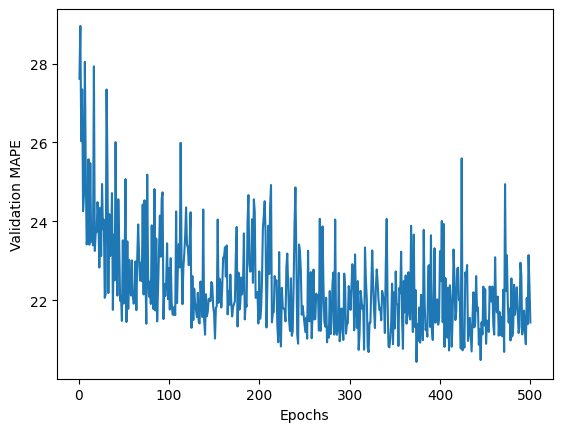

In [80]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAPE')
plt.show()

Формирование графика с оценками проверок за исключением первых 10 замеров

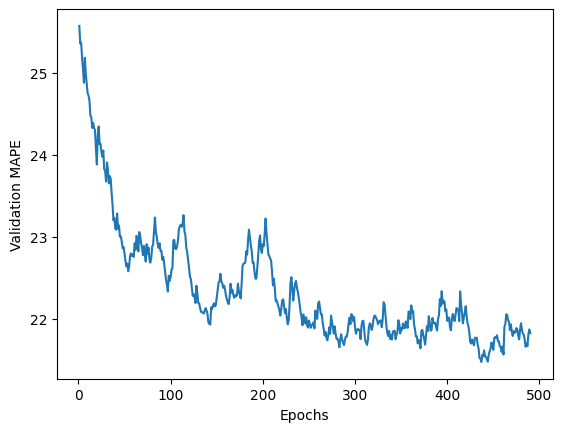

In [81]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAPE')
plt.show()


Обучение окончательной версии модели

In [82]:
model = build_model()
model.fit(train_data, train_targets,
 epochs=460, batch_size=13, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/460
12376/12376 [==============================] - 11s 831us/step - loss: 3.4971 - mape: 29.6259
Epoch 2/460
12376/12376 [==============================] - 10s 818us/step - loss: 3.0887 - mape: 26.5636
Epoch 3/460
12376/12376 [==============================] - 11s 873us/step - loss: 2.9986 - mape: 25.8720
Epoch 4/460
12376/12376 [==============================] - 11s 884us/step - loss: 2.9303 - mape: 25.3621
Epoch 5/460
12376/12376 [==============================] - 10s 828us/step - loss: 2.8822 - mape: 25.0659
Epoch 6/460
12376/12376 [==============================] - 10s 815us/step - loss: 2.8435 - mape: 24.8676
Epoch 7/460
12376/12376 [==============================] - 10s 815us/step - loss: 2.8105 - mape: 24.6560
Epoch 8/460
12376/12376 [==============================] - 10s 820us/step - loss: 2.7773 - mape: 24.4978
Epoch 9/460
12376/12376 [==============================] - 10s 814us/step - loss: 2.7548 - mape: 24.3661
Epoch 10/460
12376/12376 [=============================

In [83]:
from keras.models import load_model 
model.save("network_21.4%.h5") 